# Plan of action
- Clean the data
- Visualize and explore
- Perform cluster analysis (PCA)
- Establish basic model
- Look for feature interaction
- Engineer some features if possible

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
# Load the data

In [4]:
data_folder = "/Users/dominguez/Documents/Kaggle_G_Research_Crypto/data/"
train = pd.read_csv(data_folder + "train.csv")
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [5]:
train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [6]:
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [60]:
# What is the time range for our dataset
train_start_date = datetime.fromtimestamp(min(train.timestamp)).strftime('%Y-%m-%d %H:%M:%S')
train_end_date = datetime.fromtimestamp(max(train.timestamp)).strftime('%Y-%m-%d %H:%M:%S')
print(train_start_date)
print(train_end_date)

2017-12-31 16:01:00
2021-09-20 17:00:00


In [ ]:
# Clean the data

In [7]:
# Change the timestamp format
#train["timestamp"] = pd.to_datetime(train['timestamp'], unit='s')

In [8]:
# Let's take a look at couple assets, Bitcoin (Asset_ID = 1) & Etherium (Asset_ID = 6)
btc = train[train["Asset_ID"] == 1].set_index("timestamp")
eth = train[train["Asset_ID"] == 6].set_index("timestamp")

In [9]:
btc_sample = btc.iloc[-300:]

fig = go.Figure(
    data=[
        go.Candlestick(
            x=btc_sample.index,
            open=btc_sample['Open'],
            high=btc_sample['High'],
            low=btc_sample["Low"],
            close=btc_sample['Close']
        )
    ]
)
fig.show()

In [10]:
eth_sample = eth.iloc[-300:]

fig = go.Figure(
    data=[
        go.Candlestick(
            x=eth_sample.index,
            open=eth_sample['Open'],
            high=eth_sample['High'],
            low=eth_sample["Low"],
            close=eth_sample['Close']
        )
    ]
)
fig.show()

In [11]:
# Time range for BTC and ETH

In [12]:
beg_btc = btc.index[0]
end_btc = btc.index[-1]
beg_eth = eth.index[0]
end_eth = eth.index[-1]

print('BTC data goes from ', beg_btc, 'to ', end_btc)
print('Ethereum data goes from ', beg_eth, 'to ', end_eth)

BTC data goes from  1514764860 to  1632182400
Ethereum data goes from  1514764860 to  1632182400


In [13]:
# Fix gaps in time range
# Missing data, for a given minute, is not represented by NaNs, but instead by the absense of rows
# We can check the timestamp difference between consecutive rows to see if there is missing data.

In [14]:
(btc.index[1:] - btc.index[:-1]).value_counts().head()

60     1956136
120         78
180         12
240         11
420          9
Name: timestamp, dtype: int64

In [15]:
(eth.index[1:] - eth.index[:-1]).value_counts().head()

60     1956043
120        100
180         23
300          5
540          4
Name: timestamp, dtype: int64

In [16]:
# Use .reindex() to fill the gaps
btc = btc.reindex(range(btc.index[0], btc.index[-1] + 60, 60), method='pad')
(btc.index[1:] - btc.index[:-1]).value_counts().head()

60    1956959
Name: timestamp, dtype: int64

In [17]:
eth = eth.reindex(range(eth.index[0], eth.index[-1] + 60, 60), method='pad')
(eth.index[1:] - eth.index[:-1]).value_counts().head()

60    1956959
Name: timestamp, dtype: int64

# Visualize and Explore

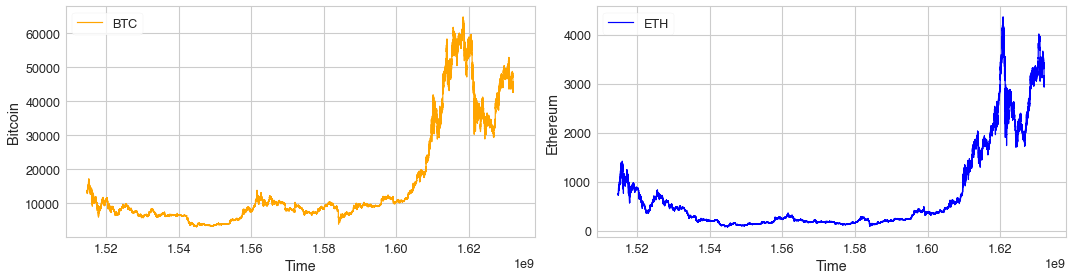

In [18]:
# plot vwap time series for both chosen assets
f = plt.figure(figsize=(15,4))

ax = f.add_subplot(121)
plt.plot(btc['VWAP'], color='orange', label='BTC')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')

ax2 = f.add_subplot(122)
ax2.plot(eth['VWAP'], color='blue', label='ETH')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum')

plt.tight_layout()
plt.show()

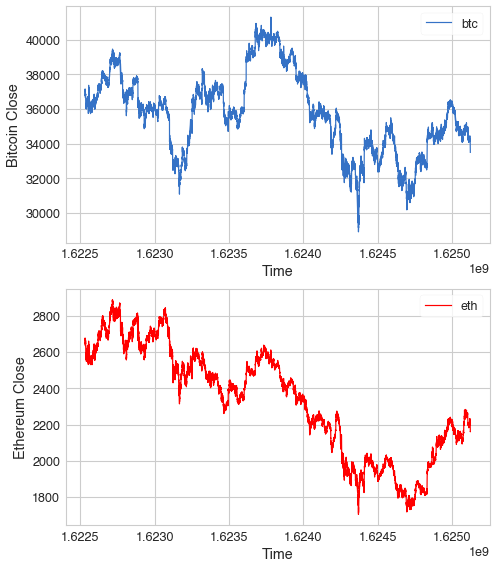

In [19]:
import time
# Are they correlated in recent history?
totimestamp = lambda s: np.int32(
    time.mktime(
        datetime.strptime(
            s, "%d/%m/%Y"
            ).timetuple()
        )
    )

# create intervals
btc_mini_2021 = btc.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]
eth_mini_2021 = eth.loc[totimestamp('01/06/2021'):totimestamp('01/07/2021')]

# plot time series for both chosen assets
f = plt.figure(figsize=(7,8))

ax = f.add_subplot(211)
plt.plot(btc_mini_2021['Close'], label='btc')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin Close')

ax2 = f.add_subplot(212)
ax2.plot(eth_mini_2021['Close'], color='red', label='eth')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum Close')

plt.tight_layout()
plt.show()

In [20]:
# Looks like there may be some correlation with the ups and downs of both assets
# Let's compare log returns

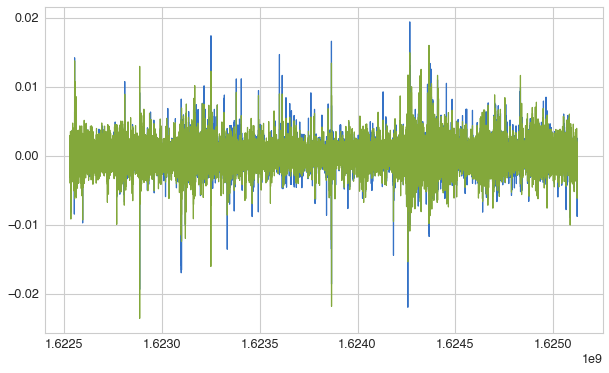

In [21]:
import scipy.stats as stats

def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

lret_btc = log_return(btc_mini_2021.Close)[1:]
lret_eth = log_return(eth_mini_2021.Close)[1:]
lret_btc.rename('lret_btc', inplace=True)
lret_eth.rename('lret_eth', inplace=True)

plt.figure(figsize=(10,6))
plt.plot(lret_btc);
plt.plot(lret_eth);
plt.show()

In [22]:
# Correlation between assets

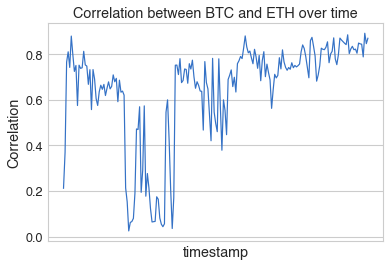

In [23]:
# join two asset in single DataFrame
lret_btc_long = log_return(btc.Close)[1:]
lret_eth_long = log_return(eth.Close)[1:]
lret_btc_long.rename('lret_btc', inplace=True)
lret_eth_long.rename('lret_eth', inplace=True)

two_assets = pd.concat([lret_btc_long, lret_eth_long], axis=1)

# group consecutive rows and use .corr() for correlation between columns
corr_time = two_assets.groupby(two_assets.index//(10000*60)).corr().loc[:,"lret_btc"].loc[:,"lret_eth"]

corr_time.plot();
plt.xticks([])
plt.ylabel("Correlation")
plt.title("Correlation between BTC and ETH over time");

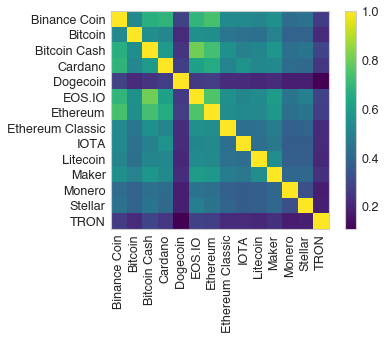

In [24]:
# create dataframe with returns for all assets
all_assets_2021 = pd.DataFrame([])
for asset_id, asset_name in zip(asset_details.Asset_ID, asset_details.Asset_Name):
  asset = train[train["Asset_ID"]==asset_id].set_index("timestamp")
  asset = asset.loc[totimestamp('01/01/2021'):totimestamp('01/05/2021')]
  asset = asset.reindex(range(asset.index[0],asset.index[-1]+60,60),method='pad')
  lret = log_return(asset.Close.fillna(0))[1:]
  all_assets_2021 = all_assets_2021.join(lret, rsuffix=asset_name, how="outer")

# Calc correlated returns
plt.imshow(all_assets_2021.corr());
plt.yticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values);
plt.xticks(asset_details.Asset_ID.values, asset_details.Asset_Name.values, rotation='vertical');
plt.colorbar();
plt.grid(b=None);

In [25]:
# Building your prediction model

In [26]:
# Prediction Targets and Evaluation

https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition?cellIds=51&kernelSessionId=78721864

In [27]:
# Feature Design

In [1]:
# First, let's design a few relevant featured to input to our model

In [35]:
# Select some input features from the trading data: 
# 5 min log return, abs(5 min log return), upper shadow, and lower shadow.
upper_shadow = lambda asset: asset.High - np.maximum(asset.Close,asset.Open)
lower_shadow = lambda asset: np.minimum(asset.Close,asset.Open) - asset.Low

X_btc = pd.concat([log_return(btc.VWAP,periods=5), log_return(btc.VWAP,periods=1).abs(), 
               upper_shadow(btc), lower_shadow(btc)], axis=1)
y_btc = btc.Target

X_eth = pd.concat([log_return(eth.VWAP,periods=5), log_return(eth.VWAP,periods=1).abs(), 
               upper_shadow(eth), lower_shadow(eth)], axis=1)
y_eth = eth.Target

In [ ]:
# Preparing the data for building predictive models

In [38]:
# select training and test periods
train_window = [totimestamp("01/05/2021"), totimestamp("30/05/2021")]
test_window = [totimestamp("01/06/2021"), totimestamp("30/06/2021")]

# divide data into train and test, compute X and y
# we aim to build simple regression models using a window_size of 1
X_btc_train = X_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  # filling NaN's with zeros
y_btc_train = y_btc.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_btc_test = X_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_btc_test = y_btc.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 

X_eth_train = X_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  
y_eth_train = y_eth.loc[train_window[0]:train_window[1]].fillna(0).to_numpy()  

X_eth_test = X_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy() 
y_eth_test = y_eth.loc[test_window[0]:test_window[1]].fillna(0).to_numpy()

# Standardize the input data
from sklearn.preprocessing import StandardScaler
# simple preprocessing of the data 
scaler = StandardScaler()

X_btc_train_scaled = scaler.fit_transform(X_btc_train)
X_btc_test_scaled = scaler.transform(X_btc_test)

X_eth_train_scaled = scaler.fit_transform(X_eth_train)
X_eth_test_scaled = scaler.transform(X_eth_test)

In [ ]:
# Baseline model: Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression

# implement basic ML baseline (one per asset)
lr = LinearRegression()
lr.fit(X_btc_train_scaled,y_btc_train)
y_pred_lr_btc = lr.predict(X_btc_test_scaled)

lr.fit(X_eth_train_scaled,y_eth_train)
y_pred_lr_eth = lr.predict(X_eth_test_scaled)

In [42]:
# implement more complex baseline (multiple output regression model)
from sklearn.multioutput import MultiOutputRegressor

# we concatenate X and y for both assets
X_both_train = np.concatenate((X_btc_train_scaled, X_eth_train_scaled), axis=1)
X_both_test = np.concatenate((X_btc_test_scaled, X_eth_test_scaled), axis=1)
y_both_train = np.column_stack((y_btc_train, y_eth_train))
y_both_test = np.column_stack((y_btc_test, y_eth_test))

# define the direct multioutput model and fit it
mlr = MultiOutputRegressor(LinearRegression())
lr.fit(X_both_train,y_both_train)
y_pred_lr_both = lr.predict(X_both_test)

In [ ]:
# Evaluate baselines

In [43]:
print('Test score for LR baseline: BTC', f"{np.corrcoef(y_pred_lr_btc, y_btc_test)[0,1]:.2f}", 
                                ', ETH', f"{np.corrcoef(y_pred_lr_eth, y_eth_test)[0,1]:.2f}")
print('Test score for multiple output LR baseline: BTC', f"{np.corrcoef(y_pred_lr_both[:,0], y_btc_test)[0,1]:.2f}", 
                                                ', ETH', f"{np.corrcoef(y_pred_lr_both[:,1], y_eth_test)[0,1]:.2f}")

Test score for LR baseline: BTC -0.01 , ETH 0.02
Test score for multiple output LR baseline: BTC 0.00 , ETH 0.05
